<a href="https://colab.research.google.com/github/AmandinChyba/Project1-Fields-2022/blob/main/root_finding/MultipleRoots_Algorithm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import jax
import jax.lax as lax
import jax.numpy as jnp
import jax.random as jrandom
import matplotlib.pyplot as plt
import time
from functools import partial
import numpy as np

look into using vmap instead of repeat and some of these other weird processes

In [5]:
#@jax.jit
def poop():
  y = jnp.array([[1, 2, 3],[4, 5, 6]])
  p = jnp.array([[1, 2, 3],[3, 2, 1]])
  # for some reason you have to flatten the array when repeating
  final = jnp.repeat(y, p, total_repeat_length=12)
  final = final.reshape((2,6))
  return final

print(poop())

[[1 2 2 3 3 3]
 [4 4 4 5 5 6]]


In [ ]:
@jax.jit
def signDistance(t):
  # derivative must be upper bounded by 1 since its supposed to be a signed distance function
  #return 3*jnp.power(t,2) + t + 1
  #return (t-0.01)*(t-0.02)*(t-0.98)*(t-0.99)
  return jnp.sin(t)

In [ ]:
@jax.jit
def bisection(p0, p1, rootSteps, dir):
  current = 0

  def bisectionStep(i, current):
    next = current + jnp.power(0.5,i+1)
    dist1 = signDistance(p0 + dir * next * (p1 - p0))
    dist2 = signDistance(p0 + dir * current * (p1 - p0))
    return jnp.where(dist1 * dist2 > 0, next, current)

  current = lax.fori_loop(0, rootSteps, bisectionStep, current)
  
  return p0 + dir * current * (p1 - p0)

In [ ]:
#@partial(jax.jit, static_argnames=['uni_cuts', 'quad_cuts'])
def createQuadrature(uni_cuts, quad_cuts, lb, ub, epsilon=0.1):
  t0 = jnp.linspace(lb, ub, uni_cuts)
  v0 = jnp.abs(signDistance(t0))

  # quad_cuts should be greater than or equal to uni_cuts? not true?
  '''
  # threshold variation
  threshold = jnp.min(v0) + epsilon
  n_close = jnp.count_nonzero(v0 < threshold)
  p = (quad_cuts - uni_cuts)/n_close
  lol = jnp.where(v0 < threshold, p, 0)
  lol = jnp.floor(lol).astype(int)
  lol = lol + 1
  # tag the extra points at the end?
  extra = quad_cuts % jnp.sum(lol)
  lol = lol.at[-1].add(extra)
  h = 1 / (uni_cuts * lol)
  xd1 = jnp.repeat(lol, h)
  xd1 = jnp.cumsum(xd1)
  xd  = xd * (ub - lb) / xd[-1] + lb
  '''
  '''
  # percentage variation
  v0 = v0 + epsilon
  v0 = 1 / v0
  v0 = v0 / jnp.sum(v0)
  lol = (quad_cuts - uni_cuts) * v0
  lol = jnp.floor(lol).astype(int)
  lol = lol + 1
  # tag the extra points at the end?
  extra = quad_cuts % jnp.sum(lol)
  lol = lol.at[-1].add(extra)
  h = 1 / (uni_cuts * lol)
  xd1 = jnp.repeat(lol, h)
  xd1 = jnp.cumsum(xd1)
  xd  = xd * (ub - lb) / xd[-1] + lb
  '''
  
  # smart variation
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = uni_space / 2
  n_close = jnp.count_nonzero(v0 < threshold)
  
  spacing_amount = ((quad_cuts - uni_cuts) // n_close).astype(int) + 1
  spacing_value = uni_space / (spacing_amount)

  h = jnp.where(v0 < threshold, spacing_amount, 1)
  lol = jnp.where(v0 < threshold, spacing_value, uni_space)

  extra = quad_cuts % n_close
  h = h.at[-1].add(extra)

  '''
  # experimental:
  uni_space = (ub - lb) / (uni_cuts - 1)
  threshold = uni_space / 2
  n_close = jnp.count_nonzero(v0 < threshold)
  lol2 = jnp.where(v0 < threshold, v0, 0)
  lol2 = 1 / lol2
  lol2 = jnp.where(jnp.isinf(lol2), 0, lol2)
  lol2 = lol2 / jnp.sum(lol2)
  # smooth the distribution at this point?
  lol2 = lol2 * (quad_cuts - uni_cuts)
  lol2 = jnp.floor(lol2).astype(int)
  lol2 += 1
  extra = jnp.sum(lol2) % n_close
  lol2 = lol2.at[-1].add(extra)
  h2 = uni_space * 1 / lol2
  print("lol2",lol2)
  print("h2",h2)
  h = lol2
  lol = h2
  '''


  xd = jnp.repeat(lol, h, total_repeat_length=quad_cuts)
  xd = jnp.cumsum(xd)
  #xd -= uni_space / 2 + spacing_value / 2
  xd -= uni_space / 2
  xd += lb
  
  #print("v0",v0)
  #print("close points:", n_close)
  #print("uniform spacing:", uni_space)
  #print("threshold:", threshold)
  #print("spacing amount:", spacing_amount)
  #print("spacing value:", spacing_value)
  #print("extra:", extra)
  #print("lol",lol)
  #print("h",h)
  #print("xd",xd)
  '''
  xd = np.zeros(quad_cuts)
  i = 0
  j = 0
  k = 0
  for counter in range(quad_cuts + uni_cuts - n_close):
      if k == h[j] or h[j] == 0:
        j += 1
        k = 0
      
      if h[j] != 0:
        xd[i] = t0[j] + spacing_value * k - threshold + spacing_value / 2
        i += 1
      
      k += 1
  
  # not jitable because of jnp.arange(spacing_amount)
  xd1 = jnp.repeat(t0, h, total_repeat_length=quad_cuts)
  xd2 = jnp.resize(jnp.arange(spacing_amount), quad_cuts)
  xd = xd1 + spacing_value * xd2 - threshold + spacing_value / 2
  '''

  return xd

In [ ]:
#@jax.jit
def rootIsolate(key, t):
  # find the roots
  v = signDistance(t)
  v = jnp.where(v > 0, 1, -1)
  roots = v[:-1] + v[1:]

  # check how many roots
  n_zeros = jnp.count_nonzero(roots == 0)
  #print('number of roots found:', n_zeros)

  # randomly pick a root
  p = jnp.where(roots == 0, 1/n_zeros, 0)
  indices = jnp.arange(0, len(roots))
  root_index = jrandom.choice(key, indices, (), p=p)

  # find the bounds containing that root
  lb = t[root_index]
  ub = t[root_index + 1]
  
  # return the roots interval
  return lb, ub

In [ ]:
%%time
key = jrandom.PRNGKey(int(time.time()))

uni_cuts = 10
quad_cuts = 20
lb=5
ub=10
epsilon=0.01

# must always have more uni_cuts then there are roots
# more quad_cuts means you should pick a smaller confidence
quadrature = createQuadrature(uni_cuts, quad_cuts, lb=lb, ub=ub, epsilon=epsilon)
t, t2 = rootIsolate(key, quadrature)
root = bisection(t, t2, 10, dir=1)

# use "t, t2, dir" to find the sign of the normal

print('t:', root)
print('f(t):', signDistance(root))

t: 9.424732
f(t): 4.5752517e-05
CPU times: user 3.17 s, sys: 54.5 ms, total: 3.22 s
Wall time: 8.03 s


[ 5.2777777  5.8333335  5.925926   6.0185184  6.111111   6.203704
  6.296296   6.388889   6.9444447  7.5        8.055555   8.611111
  9.166667   9.25926    9.351852   9.444445   9.537037   9.62963
  9.722223  10.277779 ]


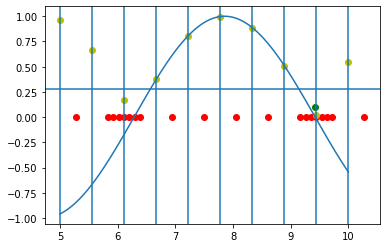

In [ ]:
t = jnp.linspace(lb, ub, 500)
plt.plot(t, signDistance(t))

plt.scatter(root, 0.1, c='g')

quadrature_zeros = jnp.zeros(len(quadrature))
plt.scatter(quadrature, quadrature_zeros, c='r')

t0 = jnp.linspace(lb, ub, uni_cuts)
v0 = jnp.abs(signDistance(t0))
threshold = (ub - lb) / (uni_cuts - 1)
plt.scatter(t0, v0, c='y')
plt.axhline(threshold / 2, linestyle='-')
for t in t0:
  plt.axvline(t, linestyle='-')

print(quadrature)